# Library import

In [1]:
!pip install yfinance

import math
import numpy as np
import tqdm
import matplotlib.pyplot as plt
import torch
import torch.nn as nn


from pandas_datareader import data as wb
import yfinance as yfin
yfin.pdr_override()

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# Get and Setting Data 

[*********************100%***********************]  1 of 1 completed


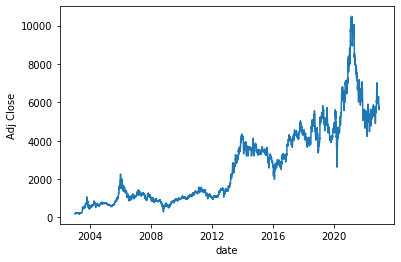

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2003-01-01,225.833328,225.833328,225.833328,225.833328,203.087509,0
2003-01-02,225.833328,225.833328,225.833328,225.833328,203.087509,0
2003-01-03,225.833328,225.833328,225.833328,225.833328,203.087509,0
2003-01-06,231.666672,233.500000,229.166672,230.666672,207.434036,25549200
2003-01-07,234.833328,235.333328,224.666672,225.833328,203.087509,33570000
...,...,...,...,...,...,...
2022-12-26,5772.000000,5824.000000,5728.000000,5778.000000,5778.000000,5392700
2022-12-27,5797.000000,5870.000000,5785.000000,5796.000000,5796.000000,6626000
2022-12-28,5770.000000,5785.000000,5680.000000,5711.000000,5711.000000,7324500


In [2]:
# Parameter for data
## Security code
stock_code='9984.T'
## Start Date
start_date='2003-1-1'
## End Date
end_date='2022-12-31'
## Split ratio of train data and validation data
train_rate=0.7
## How many business days to see
observation_period_num=60
## How many business days to predict
predict_period_num=5

# Parameter for mdoel
## Learning Rate
lr=0.00005
## Epoch Number
epochs=1000
## Mini-Batch size
batch_size=64
## How many epochs to stop train if valid loss is not decreasing
patience=20

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Get data
df=wb.DataReader(stock_code,start=start_date,end=end_date)

# Plot 'Adj Close' values
plt.plot(df.iloc[:,-2])
plt.xlabel('date')
plt.ylabel('Adj Close')
plt.show()

df

In [3]:
# Normalization
mean_list=df.mean().values
std_list=df.std().values
df=(df-mean_list)/std_list
df

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2003-01-01,-1.226570,-1.228439,-1.224445,-1.226565,-1.189981,-0.600465
2003-01-02,-1.226570,-1.228439,-1.224445,-1.226565,-1.189981,-0.600465
2003-01-03,-1.226570,-1.228439,-1.224445,-1.226565,-1.189981,-0.600465
2003-01-06,-1.223805,-1.224852,-1.222845,-1.224274,-1.187910,-0.211182
2003-01-07,-1.222304,-1.223994,-1.225005,-1.226565,-1.189981,-0.088972
...,...,...,...,...,...,...
2022-12-26,1.402268,1.390887,1.415940,1.405666,1.467345,-0.518298
2022-12-27,1.414118,1.412410,1.443293,1.414200,1.475924,-0.499507
2022-12-28,1.401320,1.372639,1.392905,1.373902,1.435408,-0.488864


In [4]:
# Array initialization
inout_data=[]

# Put data in array
for i in range(len(df)-observation_period_num-predict_period_num):
  data=df.iloc[i:i+observation_period_num,4].values
  label=df.iloc[i+predict_period_num:i+observation_period_num++predict_period_num,4].values
  inout_data.append((data,label))
inout_data=torch.FloatTensor(inout_data)

train_data=inout_data[:int(np.shape(inout_data)[0]*train_rate)].to(device)
valid_data=inout_data[int(np.shape(inout_data)[0]*train_rate):].to(device)

print('train data：',np.shape(train_data)[0])
print('valid data：',np.shape(valid_data)[0])

<ipython-input-4-56657d0d15b8>:9: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:230.)
  inout_data=torch.FloatTensor(inout_data)


train data： 3437
valid data： 1474


# Model Definition

In [5]:
# Define a function for getting mini-batch
def get_batch(source, i, batch_size):
  seq_len=min(batch_size, len(source)-1-i)
  data=source[i:i+seq_len]
  input=torch.stack(torch.stack([item[0] for item in data]).chunk(observation_period_num,1))
  target=torch.stack(torch.stack([item[1] for item in data]).chunk(observation_period_num,1))

  return input, target

In [6]:
# Functions for positional encoding
class PositionalEncoding(nn.Module):
  def __init__(self,d_model,max_len=5000):
    super().__init__()
    self.dropout=nn.Dropout(p=0.1)
    pe=torch.zeros(max_len, d_model)
    position=torch.arange(0, max_len,dtype=torch.float).unsqueeze(1)
    div_term=torch.exp(torch.arange(0,d_model, 2).float()*(-math.log(10000.0)/d_model))
    pe[:,0::2]=torch.sin(position*div_term)
    pe[:,1::2]=torch.cos(position*div_term)
    pe=pe.unsqueeze(0).transpose(0,1)
    self.register_buffer("pe",pe)
  
  def forward(self,x):
    return self.dropout(x+self.pe[:np.shape(x)[0],:])

In [7]:
# Transformer model definition
class TransformerModel(nn.Module):
  def __init__(self,feature_size=250,num_layers=1,dropout=0.1):
    super().__init__()
    self.model_type='Transformer'
    self.src_mask=None
    self.device=torch.device("cuda" if torch.cuda.is_available() else "cpu")
    self.pos_encoder=PositionalEncoding(d_model=feature_size)
    self.encoder_layer=nn.TransformerEncoderLayer(d_model=feature_size,nhead=10,dropout=dropout)
    self.transformer_encoder=nn.TransformerEncoder(self.encoder_layer,num_layers=num_layers)
    self.decoder=nn.Linear(feature_size,1)
  
  def init_weights(self):
    self.decoder.bias.data.zero_()
    self.decoder.weight.data.uniform(-0.1,0.1)

  def _generate_square_subsequent_mask(self,sz):
    mask=(torch.triu(torch.ones(sz,sz))==1).transpose(0,1)
    mask=mask.float().masked_fill(mask==0,float('-inf')).masked_fill(mask==1,float(0.0))
    return mask

  def forward(self,src):
    if self.src_mask is None or self.src_mask.size(0)!=len(src):
      device=self.device
      mask=self._generate_square_subsequent_mask(len(src)).to(device)
      self.src_mask=mask
    src=self.pos_encoder(src)
    output=self.transformer_encoder(src,self.src_mask)
    output=self.decoder(output)
    return output

In [8]:
# Function for early stop of train if valid loss is not decreasing
class EarlyStopping:
    def __init__(self,patience=5):
        self.patience=patience
        self.counter=0
        self.best_score=None
        self.early_stop=False
        self.val_loss_min=np.Inf
        
    def __call__(self,val_loss,model):
        score=(-val_loss)
        if self.best_score is None:
            self.best_score=score
        elif score<self.best_score:
            self.counter+=1
            if self.counter>=self.patience:
                self.early_stop=True
        else:
            self.best_score=score
            self.counter=0

# Train

 10:epoch | 0.000321192 : train loss | 0.4344853 : valid loss
 20:epoch | 0.0001995042 : train loss | 0.350406 : valid loss
 30:epoch | 0.0001586617 : train loss | 0.3173122 : valid loss
 40:epoch | 0.0001412514 : train loss | 0.3085649 : valid loss
 50:epoch | 0.0001320529 : train loss | 0.3048308 : valid loss
 60:epoch | 0.0001268646 : train loss | 0.3008848 : valid loss
 70:epoch | 0.0001230134 : train loss | 0.2999121 : valid loss
 80:epoch | 0.0001212591 : train loss | 0.2996557 : valid loss
 90:epoch | 0.0001196461 : train loss | 0.2998424 : valid loss
 93:epoch | 0.0001187361 : train loss | 0.3000122 : valid loss
Early Stop


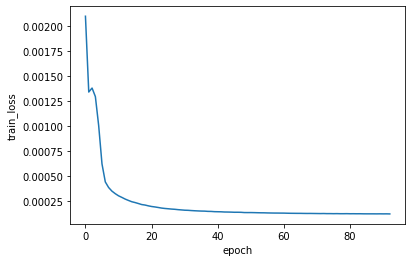

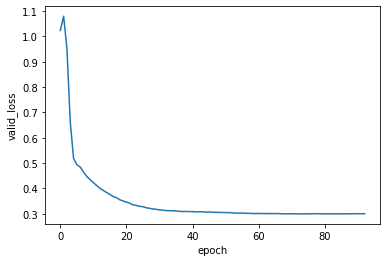

In [9]:
model=TransformerModel().to(device)
criterion=nn.MSELoss()

optimizer=torch.optim.AdamW(model.parameters(),lr=lr)
scheduler=torch.optim.lr_scheduler.StepLR(optimizer,1.0,gamma=0.95)
earlystopping=EarlyStopping(patience)

train_loss_list=[]
valid_loss_list=[]

for epoch in range(1,epochs+1):
  # train
  model.train()
  total_loss_train=0.0
  for batch, i in enumerate(range(0,len(train_data),batch_size)):
    data,targets=get_batch(train_data,i,batch_size)
    optimizer.zero_grad()
    output=model(data)
    loss=criterion(output,targets)
    loss.backward()
    optimizer.step()
    total_loss_train+=loss.item()
  scheduler.step()
  total_loss_train=total_loss_train/len(train_data)

  #valid
  model.eval()
  total_loss_valid=0.0
  for i in range(0,len(valid_data),batch_size):
    data,targets=get_batch(valid_data,i,batch_size)
    output=model(data)
    total_loss_valid+=len(data[0])*criterion(output, targets).cpu().item()
  total_loss_valid=total_loss_valid/len(valid_data)

  #etc
  train_loss_list.append(total_loss_train)
  valid_loss_list.append(total_loss_valid)
  if epoch%10==0:
    print(f'{epoch:3d}:epoch | {total_loss_train:5.7} : train loss | {total_loss_valid:5.7} : valid loss')
  earlystopping((total_loss_valid),model)
  if earlystopping.early_stop:
    print(f'{epoch:3d}:epoch | {total_loss_train:5.7} : train loss | {total_loss_valid:5.7} : valid loss')
    print("Early Stop")
    break

plt.xlabel('epoch')
plt.ylabel('train_loss')
plt.plot(train_loss_list)
plt.show()

plt.xlabel('epoch')
plt.ylabel('valid_loss')
plt.plot(valid_loss_list)
plt.show()

# Test

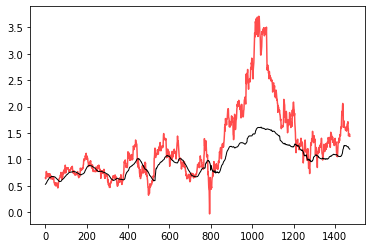

In [10]:
model.eval()
result=torch.Tensor(0)
actual=torch.Tensor(0)

with torch.no_grad():
  for i in range(0,len(valid_data)-1):
    data,target=get_batch(valid_data,i,1)
    output=model(data)
    result=torch.cat((result, output[-1].view(-1).cpu()),0)
    actual=torch.cat((actual,target[-1].view(-1).cpu()),0)

plt.plot(actual,color='red',alpha=0.7)
plt.plot(result,color='black',linewidth=1.0)
plt.show()